# Deep Learning HW 2
Referring to the workshop, "DL-PART1-TF2_Basics-Ch04-Workshop-FCDNs-MNIST_for_Digit Recognition.ipynb", complete the following taks: <br>
(1) load the dataset, "Fashion-MNIST" (https://github.com/zalandoresearch/fashion-mnist), and create a FCDN model, <br>
(2) use tf.keras.callbacks.TensorBoard to output scalars, graph, histograms, and distributions to TensorBoard, <br>
(3) use tf.summary to output a figure plot including 25 Fashion-MNIST images to TensorBoard, <br>
(4) use tf.summary to output a figure plot for Confusion Matrix to TensorBoard, <br>
(5) show all results above on https://TensorBoard.dev, and <br>
(6) provide your experiment link to TensorBoard.dev in your code. <br>

In [1]:
import tensorflow as tf
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import io # input/output
import itertools
import sklearn
from sklearn.metrics import confusion_matrix

tf.__version__

'2.13.0'

+ ### Model

In [2]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28, 1)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 111146 (434.16 KB)
Trainable params: 111146 (434.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


+ ### Import Data

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Reshape the datasets into 4D-Tensor format...
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

+ ### Backpropagation

In [5]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

+ ### Output Data for TensorBoard

In [6]:
# File-directory Path for TensorBoard 
log_dir="logs/fit/fcdn/" + datetime.now().strftime("%Y%m%d-%H%M%S")

+ #### Output Fashion_MNIST Images for TensorBoard

In [7]:
# tf.summary.create_file_writer() : 
#   Creates a summary file writer for the given log directory.
log_images = log_dir + "/images"
file_writer = tf.summary.create_file_writer(log_images)

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' 
       to a PNG image and returns it. The supplied figure 
       is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed 
    # directly inside the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def image_grid():
    """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
    # Create a figure to contain the plot.
    figure = plt.figure(figsize=(10,10))
    for i in range(25):
        # Start next subplot.
        plt.subplot(5, 5, i + 1, title=class_names[train_labels[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i], cmap=plt.cm.binary)
    return figure

def log_image_plots(epoch, logs):
    # Prepare the plot
    figure = image_grid()
    # Convert to image and log
    with file_writer.as_default():
        tf.summary.image("Training data", plot_to_image(figure), step=0)

+ #### Output Confusion Matrix for TensorBoard

In [8]:
def plot_confusion_matrix(cm, class_names):
    """ 
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
      cm (array, shape = [n, n]): a confusion matrix of integer classes
      class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 
                       decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [9]:
# tf.summary.create_file_writer() : 
#   Creates a summary file writer for the given log directory.
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

# Class names for MNIST digit images: 0 ~ 9
class_names = [str(i) for i in range(10)]

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(test_images)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

+ #### Callback

In [10]:
# Define the Keras TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# Define the per-epoch callbacks for MNIST images.
image_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_image_plots)

# Define the per-epoch callbacks for confusion matrix.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [21]:
# validation_split: Float between 0 and 1. 
#                   Fraction of the training data to be used as validation data.

history = model.fit(train_images, 
                    train_labels, 
                    epochs=10, 
                    batch_size=512,
                    validation_split=0.1,
                    callbacks=[tensorboard_callback, 
                               image_callback,
                               cm_callback])

Epoch 1/10
106/106 [==============================] - 2s 22ms/step - loss: 0.0546 - accuracy: 0.9801 - val_loss: 0.7101 - val_accuracy: 0.8837
Epoch 2/10
106/106 [==============================] - 2s 21ms/step - loss: 0.0554 - accuracy: 0.9795 - val_loss: 0.6452 - val_accuracy: 0.8843
Epoch 3/10
106/106 [==============================] - 2s 19ms/step - loss: 0.0535 - accuracy: 0.9800 - val_loss: 0.8231 - val_accuracy: 0.8753
Epoch 4/10
106/106 [==============================] - 3s 25ms/step - loss: 0.0536 - accuracy: 0.9811 - val_loss: 0.8139 - val_accuracy: 0.8772
Epoch 5/10
106/106 [==============================] - 2s 19ms/step - loss: 0.0541 - accuracy: 0.9800 - val_loss: 0.7172 - val_accuracy: 0.8770
Epoch 6/10
106/106 [==============================] - 2s 23ms/step - loss: 0.0493 - accuracy: 0.9814 - val_loss: 0.8170 - val_accuracy: 0.8677
Epoch 7/10
106/106 [==============================] - 3s 24ms/step - loss: 0.0526 - accuracy: 0.9807 - val_loss: 0.6666 - val_accuracy: 0.8903

In [22]:
test_loss, test_acc = model.evaluate(test_images, test_labels,verbose = 1)

print('\nTest accuracy:', test_acc)

313/313 [==============================] - 0s 866us/step - loss: 0.7230 - accuracy: 0.8890

Test accuracy: 0.8889999985694885


+ ### Plotting Results

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

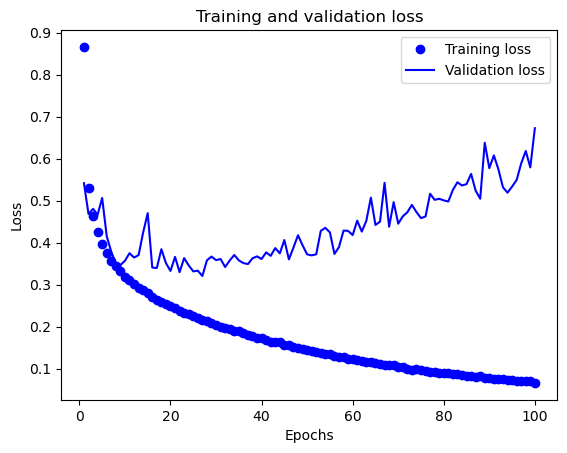

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']          
val_acc = history.history['val_accuracy']  
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

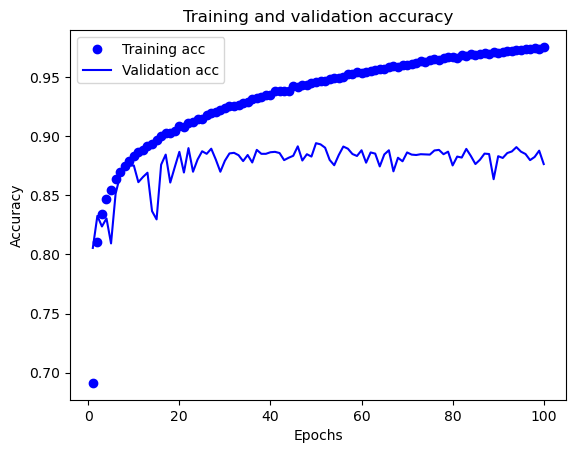

In [15]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']          
val_acc_values = history_dict['val_accuracy']  

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

+ ### Prediction

In [16]:
import numpy as np
y = model.predict(test_images)
test_predict_result = np.array([np.argmax(y[i]) for i in range(len(y))])

313/313 [==============================] - 0s 731us/step


+ ### Confusion Matrix

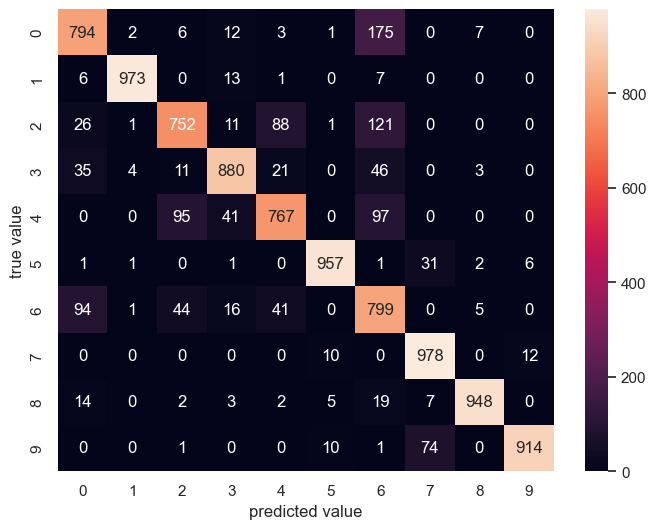

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn.metrics import confusion_matrix

mat = confusion_matrix(test_labels, test_predict_result)

plt.figure(figsize=(8,6))
sns.heatmap(mat, square=False, annot=True, fmt ='d', cbar=True)
plt.xlim((0, 10))
plt.ylim((10, 0))
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

+ ## TensorBoard
-----------------

In [23]:
%load_ext tensorboard
%tensorboard --logdir logs